# Please upvote the kernel if you found it insightful!

# Import Libraries

In [2]:
# জিনিসপাতি লোড করা, যাতে খুচরা কোড কম লেখা লাগে

import numpy as np # যেকোন ম্যাথেমেটিকাল অপারেশন করতে লাগে
import pandas as pd #এক্সেল টাইপের ডেটা লোড এবং প্রোসেস করতে লাগে
import matplotlib.pyplot as plt # ইমেজ বা চার্ট বানাতে

from sklearn.model_selection import train_test_split # মোট ডেটা থেকে ট্রেইন টেস্ট ডেটার ভাগ র্যান্ডমলি তৈরিতে লাগে

import torch # ডিপ লার্নিং করার লাইব্রেরি। এখানে কনভোলুশন, পুল এধরণের সব লিখে সেট করা আছে। চাইলে ওদের ফাংশন ডিরেক্ট কল করে ইউজ করা যায়
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2 # ইমেজ নিয়ে কাজ করতে লাগে
import albumentations as A #ডেটা অগ্মেন্টেশন করে একটা ইমেজ ডেটাকে ভিন্নরকমের ডেটা বানাতে লাগে

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch 
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp #এই মডিউলটাতে ইউনেট ধরণের নানান মডেল লিখে রাখা আছে।
# এক লাইন লিখলেই মডেল লোড হয়ে যায়। সে জন্য এটি নেওয়া হয়েছে। কাজ কমাতে। 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # ডিভাইস বলতে এখানে জিপিইউ ইউজ করা হবে যদি থাকে। না থাকলে সিপিইউতে হবে, কিন্তু সেটা হবে হাজারগুণ স্লো।

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Preprocessing

In [3]:
# নিজের ডেটাতে ট্রেইন করতে এইরকম করে নিজের ডেটা সাজিয়ে রাখবেন। এখানে
# এরিয়াল সেমান্টিক ড্রোন ডেটাসেটের উপর কাজ হয়েছে। 

IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

ক্লাসের সংখ্যা ডেটাসেট অনুযায়ী বদলাবে এখানে পরের সেল এ

In [4]:
n_classes = 23 # ক্লাসের সংখ্যা

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [5]:
df

,id
0,208
1,473
2,014
3,537
4,275
...,...
395,461
396,136
397,454
398,040


পুরো ডেটা দিয়ে ট্রেইন হবে না। তাই সেখান থেকে তিনটা অংশে ভাগ করা, এক অংশে থাকবে ট্রেইনিং
এর ডেটা, আরেক অংশে ভ্যালিডেশনের। লাস্টের টেস্ট করার জন্য আরেকটা অংশ বাদ দিয়ে রাখা হবে।

In [6]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


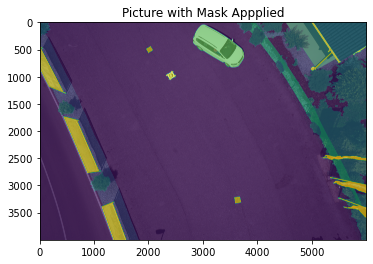

In [7]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

ফোল্ডার থেকে ডেটা লোড করে নিলেই সেটা নেটওয়ার্কে যাওয়ার উপযুক্ত হয় না। সেটার জন্য দরকার প্রোসেসিং।

এখানে 'ডেটালোডার' বানানো হয়েছে। ডেটালোডার এমন একটি জিনিস, যেটাকে প্রতিবার কল করলে আপনি
৩ টা করে ডেটা পাবেন ( যদি ব্যাচ সাইজ ৩ হয়। বেশি সেট করলে সে অনুসারে ডেটা পাবেন)। 

In [8]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# ট্রেইনিঙের ডেটার উপরে কী কী অগমেন্টেশন হবে তার লিস্ট
t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])
# ভ্যালিডেশনের ডেটার উপরে কী কী অগমেন্টেশন হবে তার লিস্ট
t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets

batch_size= 4 # প্রতিবার কয়টা করে ডেটা দিয়ে ট্রেইন করবো? এটা যত বেশি হয় ভালো। কিন্তু বেশি করলে কোড রান করবে না, জিপিইউতে ডেটা ধরবে না


#ট্রেইনিং অংশের ডেটাকে লোড করে অগ্মেন্টেশন করে ট্রেইনিংয়ের জন্য ৩ টা ৩ টা করে প্যাকেট বানিয়ে রেডি করা। 
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

#ভ্যালিডেশন অংশের ডেটাকে লোড করে অগ্মেন্টেশন করে ট্রেইনিংয়ের জন্য ৩ টা ৩ টা করে প্যাকেট বানিয়ে রেডি করা। 
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               
#dataloader




# Model

এক লাইনেই ইউনেট নামক মডেল কল করা যায় তার ওয়েইট সহ। এখানে প্রথম আর্গুমেন্টটা বদলে
নানান রকমের ইউনেট কল করা যায়। 

In [10]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [11]:
model # এখানে দেখা যাবে মডেলটার মধ্যে কী কী হয়েছে

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

# Training

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

এটা অ্যাকিউরেসি মাপার ফাংশন

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

ফিট নামক ফাংশনটার মধ্যেই সকল খেলা। এখানে, প্রতি ইপোকের জন্য পুরাটা ট্রেইনিং ডেটা একবার করে পাস হবে, ট্রেইনিং হবে, এবং ট্রেইনিং শেষ হলে ভ্যালিডেশন হবে পুরো ভ্যালিডেশন ডেটাসেটের জন্য। 

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device) # মডেলকে জিপিইউতে নিয়েছে। 
    fit_time = time.time() #কোনটা রান হতে কতক্ষণ লাগছে সেটা ট্র্যাক করার জন্য
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train() #মডেলকে ট্রেইনিং মোডে নিয়েছে
        for i, data in enumerate(tqdm(train_loader)): #একটা লুপ ঘোরাচ্ছে। প্রতিবার
                                                # ট্রেইন লোডারে বাড়ি দিবে আর ব্যাচ সাইজ পরিমাণ ডেটা লোড হবে
            #training phase
            image_tiles, mask_tiles = data #ডেটার মধ্যে আছে ইমেজ আর লেবেল (মাস্ক)। দুটোকে আলাদা করেছে এখানে
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device); #প্রতিটা ইমেজ আর মাস্ক জিপিইউতে নিচ্ছে এখানে
            #forward
            
            
            output = model(image) # ৩ টা করে ডেটা স্যাম্পল ট্রেনিং সেট থেকে নিয়ে সেটা মডেলের মধ্যে ভরেছে
            loss = criterion(output, mask) # মডেল যে আউটপুট দিয়েছে সেটার সাথে কাঙ্ক্ষিত আউটপুটের পার্থক্য লস ফাংশনের সাহায্যে বের করেছে
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward() # লসকে নেটওয়ার্কের মধ্যে ব্যাকপ্রোপাগেট করেছে
            optimizer.step() #update weight # অপটিমাইজার সবগুলো প্যারামিটারকে আপডেট করে আসবে এখানে     
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
            # এখানে ৩ টা (ব্যাচ সাইজ) পরিমাণ ইমেজের জন্য ট্রেইনিং শেষ হল। এরকম লুপ ঘুরতে থাকবে, 
            # যতক্ষণ সকল ট্রেইনিং ডেটা শেষ না হয়। 
            
        else: # এক ইপোক ট্রেইনিং শেষ হলে এখানে আসবে। এখানে ভ্যালিডেশন হবে, আর ভিন্ন ডেটার উপরে স্কোর মাপা হবে, যে আগের ইপোকের ট্রেইনিং আসলে কেমন হল?
    
            model.eval() # মডেলকে ইভ্যালুয়েশন মোডে সেট করেছে। এখন আর আপাতত ট্রেইনিং হবে না, আবারো ইভ্যালুয়েশন মোডে সেট করা পর্যন্ত।  
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad(): # গ্র্যাডিয়েন্ট ক্যাল্কুলেট করা বন্ধ করা, কারণ এখন শুধু চেকিং হবে। 
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-4 #লার্নিং রেট
epoch = 10 #ইপোক
weight_decay = 1e-4 

criterion = nn.CrossEntropyLoss() #লস ফাংশন
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))


#এটা রান দিলেই ট্রেইনিং হবে। 
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched) 

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 3.326 
Epoch:1/10.. Train Loss: 3.431.. Val Loss: 3.326.. Train mIoU:0.011.. Val mIoU: 0.014.. Train Acc:0.045.. Val Acc:0.079.. Time: 4.48m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 3.326 >> 2.459 
Epoch:2/10.. Train Loss: 2.896.. Val Loss: 2.459.. Train mIoU:0.043.. Val mIoU: 0.084.. Train Acc:0.233.. Val Acc:0.478.. Time: 4.26m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 2.459 >> 1.936 
Epoch:3/10.. Train Loss: 2.394.. Val Loss: 1.936.. Train mIoU:0.094.. Val mIoU: 0.137.. Train Acc:0.453.. Val Acc:0.641.. Time: 4.25m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.936 >> 1.454 
saving model...
Epoch:4/10.. Train Loss: 1.900.. Val Loss: 1.454.. Train mIoU:0.153.. Val mIoU: 0.175.. Train Acc:0.638.. Val Acc:0.731.. Time: 4.23m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.454 >> 1.197 
Epoch:5/10.. Train Loss: 1.579.. Val Loss: 1.197.. Train mIoU:0.168.. Val mIoU: 0.185.. Train Acc:0.677.. Val Acc:0.753.. Time: 4.30m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.197 >> 1.091 
Epoch:6/10.. Train Loss: 1.395.. Val Loss: 1.091.. Train mIoU:0.186.. Val mIoU: 0.198.. Train Acc:0.704.. Val Acc:0.756.. Time: 4.24m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.091 >> 1.037 
Epoch:7/10.. Train Loss: 1.293.. Val Loss: 1.037.. Train mIoU:0.202.. Val mIoU: 0.199.. Train Acc:0.723.. Val Acc:0.767.. Time: 4.30m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.037 >> 0.979 
Epoch:8/10.. Train Loss: 1.204.. Val Loss: 0.979.. Train mIoU:0.217.. Val mIoU: 0.228.. Train Acc:0.740.. Val Acc:0.786.. Time: 4.32m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.979 >> 0.969 
saving model...
Epoch:9/10.. Train Loss: 1.187.. Val Loss: 0.969.. Train mIoU:0.219.. Val mIoU: 0.232.. Train Acc:0.746.. Val Acc:0.784.. Time: 4.32m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:10/10.. Train Loss: 1.175.. Val Loss: 0.973.. Train mIoU:0.222.. Val mIoU: 0.226.. Train Acc:0.748.. Val Acc:0.785.. Time: 4.36m
Total time: 43.06 m


In [16]:
torch.save(model, 'Unet-Mobilenet.pt') #মডেলকে সেভ করতে। 


In [17]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

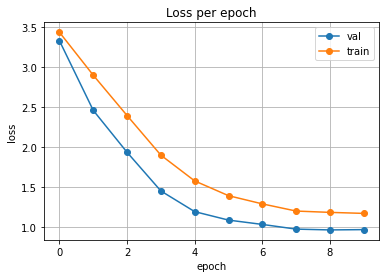

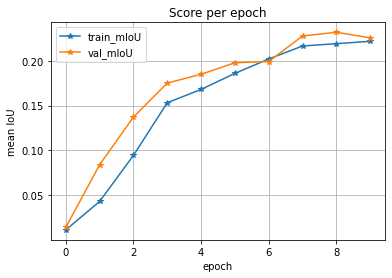

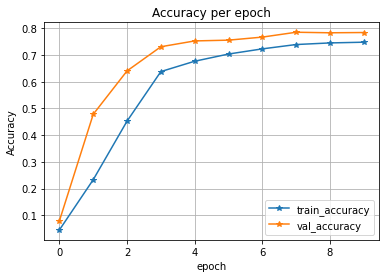

In [18]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [19]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [20]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [21]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [22]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [23]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [24]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [25]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [26]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

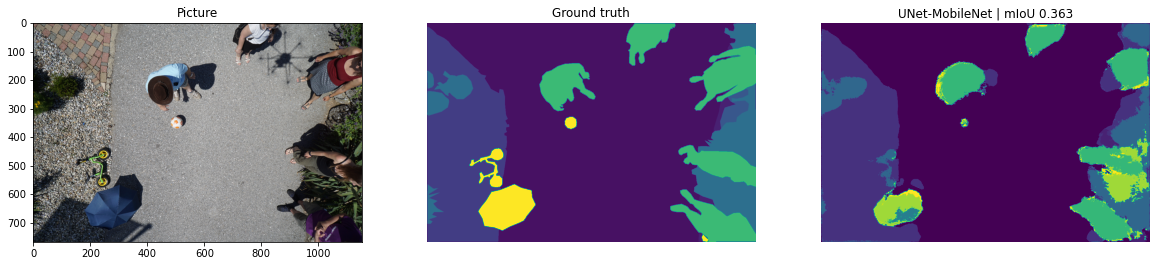

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

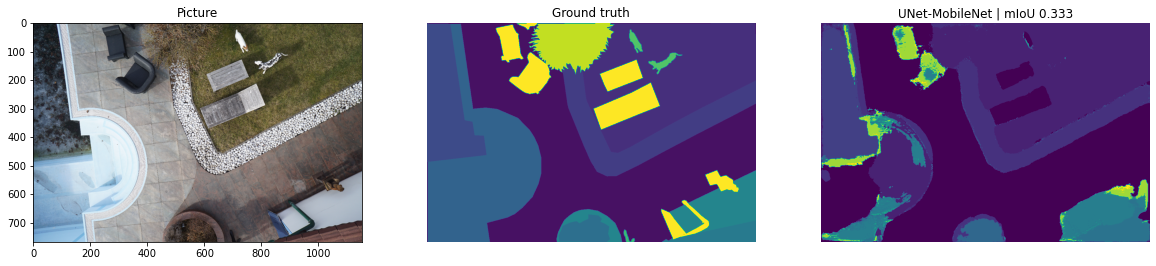

In [28]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

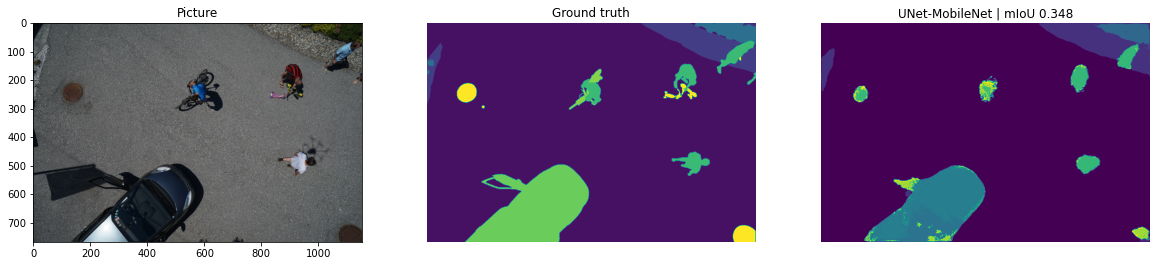

In [29]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [30]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.26236683363622915


In [31]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.7589990121346932
